In [36]:
import shap

In [37]:
import pandas as pd

# reading the data
df_heart=pd.read_csv('../data/framingham.csv')
#df_heart.replace(np.nan,"NaN")
df_heart.dropna(axis=0,inplace=True)

##separation in X and y
X_heart = df_heart.drop( columns = "TenYearCHD" )
y_heart = df_heart[ "TenYearCHD" ]

##let's start by splitting the data into a train and a validaiton set
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_heart, y_heart, stratify=y_heart, random_state=94)

In [38]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimators=100, 
                                  max_depth=3,
                                  early_stopping_rounds=10 ,
                                  eval_metric= 'auc')
model_xgb.fit(X_train, y_train, 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=True)



[0]	validation_0-auc:0.71286	validation_1-auc:0.66836
[1]	validation_0-auc:0.72418	validation_1-auc:0.68670
[2]	validation_0-auc:0.74462	validation_1-auc:0.70476
[3]	validation_0-auc:0.75311	validation_1-auc:0.71064
[4]	validation_0-auc:0.75884	validation_1-auc:0.70563
[5]	validation_0-auc:0.76692	validation_1-auc:0.71288
[6]	validation_0-auc:0.77303	validation_1-auc:0.71286
[7]	validation_0-auc:0.77598	validation_1-auc:0.71323
[8]	validation_0-auc:0.77796	validation_1-auc:0.71306
[9]	validation_0-auc:0.78357	validation_1-auc:0.70886
[10]	validation_0-auc:0.78544	validation_1-auc:0.70797
[11]	validation_0-auc:0.79030	validation_1-auc:0.70598
[12]	validation_0-auc:0.79604	validation_1-auc:0.70673
[13]	validation_0-auc:0.79797	validation_1-auc:0.70654
[14]	validation_0-auc:0.80066	validation_1-auc:0.70567
[15]	validation_0-auc:0.80402	validation_1-auc:0.70257
[16]	validation_0-auc:0.80775	validation_1-auc:0.70244


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
from sklearn.metrics import roc_auc_score
roc_auc_score( y_valid , model_xgb.predict_proba(X_valid)[:,1] )

np.float64(0.7132268412074463)

In [40]:
X_heart.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0


## SHAP basic usage and plots

In [41]:
import shap

%time explainer = shap.Explainer( model_xgb ) ## creates an explainer from our model
%time shap_values = explainer(X_train) ## compute shap values for the prediction of the models on some data

CPU times: user 229 ms, sys: 3.99 ms, total: 233 ms
Wall time: 39.9 ms
CPU times: user 109 ms, sys: 0 ns, total: 109 ms
Wall time: 12.7 ms


In [42]:
explainer

In [43]:
shap_values

.values =
array([[ 7.60801286e-02, -5.65070510e-01,  6.10176893e-03, ...,
        -2.58954172e-03, -3.40560079e-02, -3.41963246e-02],
       [-1.09939188e-01, -7.55589664e-01, -2.08885921e-03, ...,
        -2.58954172e-03,  1.78486966e-02, -1.70807779e-01],
       [ 1.02803171e-01,  2.90454447e-01, -6.09693525e-04, ...,
        -8.60842236e-04, -3.93550843e-02, -2.95284111e-02],
       ...,
       [ 1.19740315e-01, -2.40602687e-01,  1.78097631e-03, ...,
        -2.58954172e-03,  9.84774064e-03, -3.17260437e-02],
       [-7.09412247e-02, -7.76685119e-01,  6.10176893e-03, ...,
        -2.58954172e-03,  1.53696099e-02, -8.39456636e-03],
       [-7.09412247e-02, -3.41008335e-01, -6.09693525e-04, ...,
        -2.58954172e-03,  1.63427871e-02, -2.20994540e-02]], dtype=float32)

.base_values =
array([-1.7367389, -1.7367389, -1.7367389, ..., -1.7367389, -1.7367389,
       -1.7367389], dtype=float32)

.data =
array([[ 1.  , 43.  ,  4.  , ..., 28.82, 52.  , 70.  ],
       [ 0.  , 39.  ,  2.  , .

In [44]:
shap_values[:,'male']

.values =
array([ 0.07608013, -0.10993919,  0.10280317, ...,  0.11974031,
       -0.07094122, -0.07094122], dtype=float32)

.base_values =
array([-1.7367389, -1.7367389, -1.7367389, ..., -1.7367389, -1.7367389,
       -1.7367389], dtype=float32)

.data =
array([1., 0., 1., ..., 1., 0., 0.])

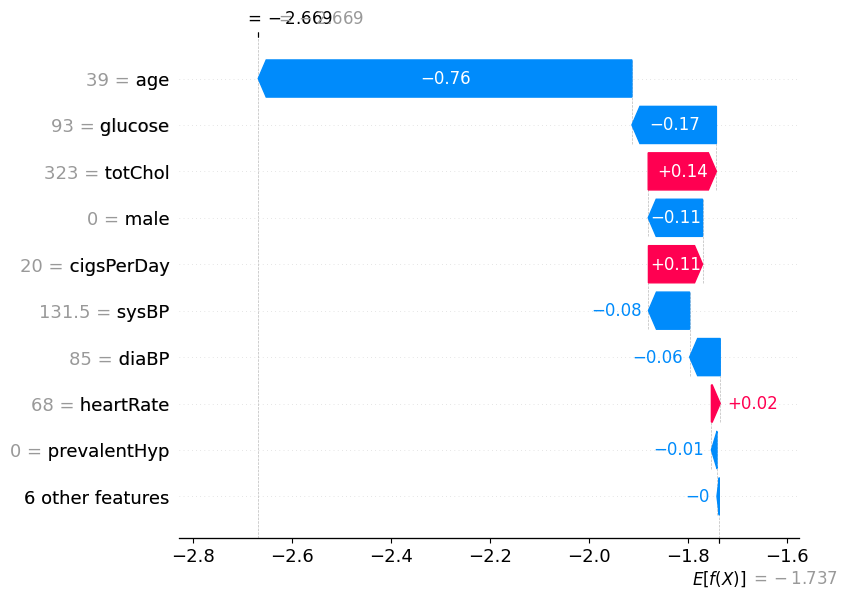

In [45]:
## explaination of a single prediction
shap.plots.waterfall(shap_values[1])

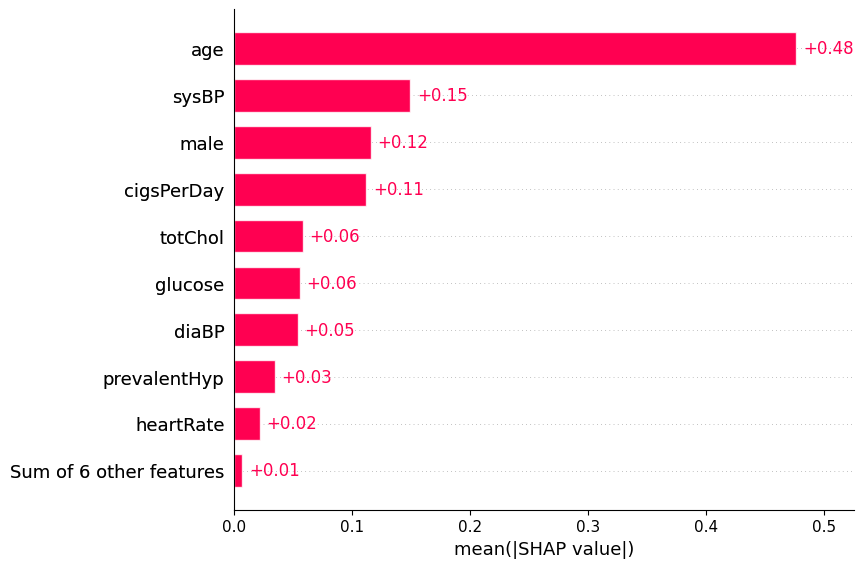

In [46]:
## average SHAP value over all predictions --> proxy of feature importance 
shap.plots.bar(shap_values)

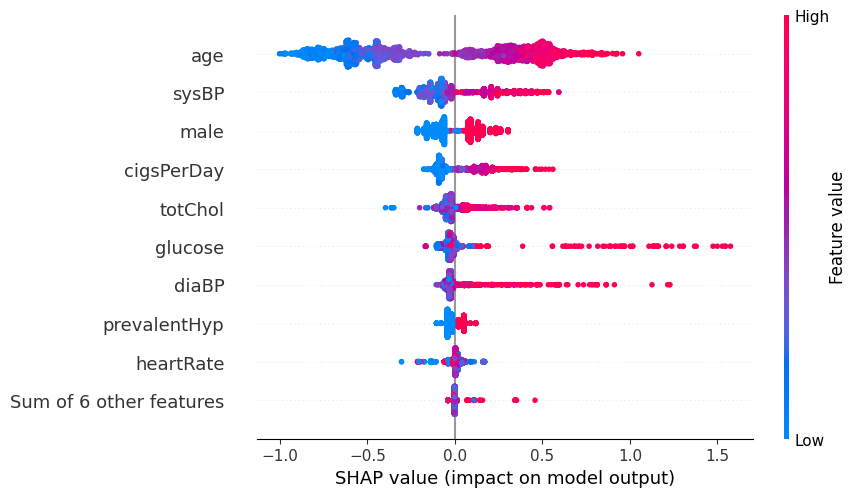

In [47]:
## beeswarm gives us a sense of the relationship between the feature values and the SHAP
shap.plots.beeswarm(shap_values)

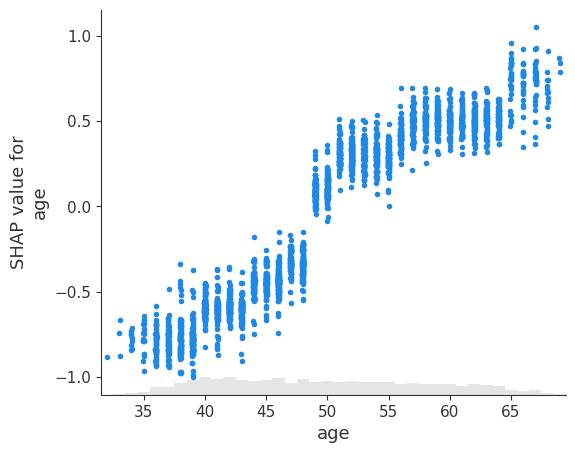

In [48]:
## plotting the SHAP value for each observed age
shap.plots.scatter( shap_values[:,'age'] )

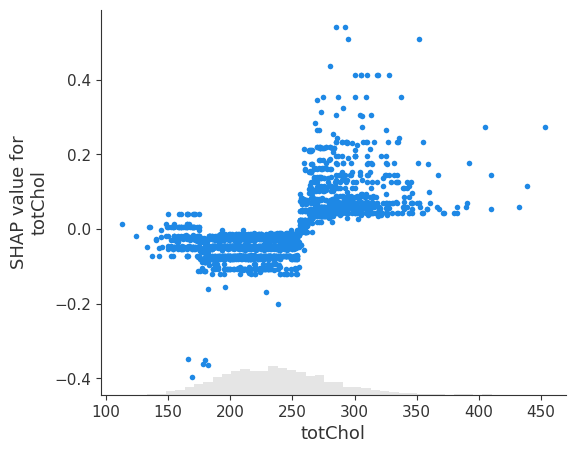

In [49]:
shap.plots.scatter( shap_values[:,'totChol'] )

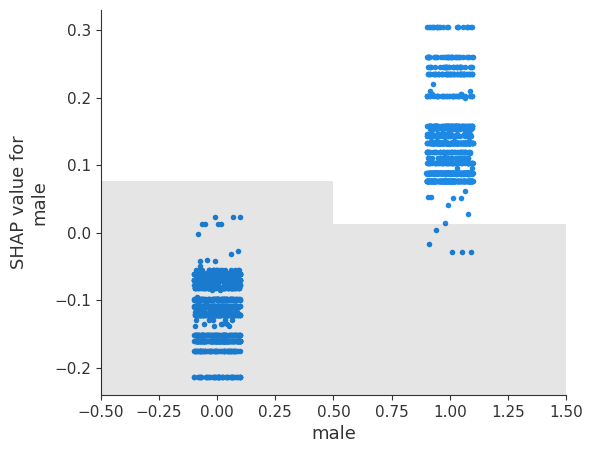

In [50]:
shap.plots.scatter( shap_values[:,'male'] )

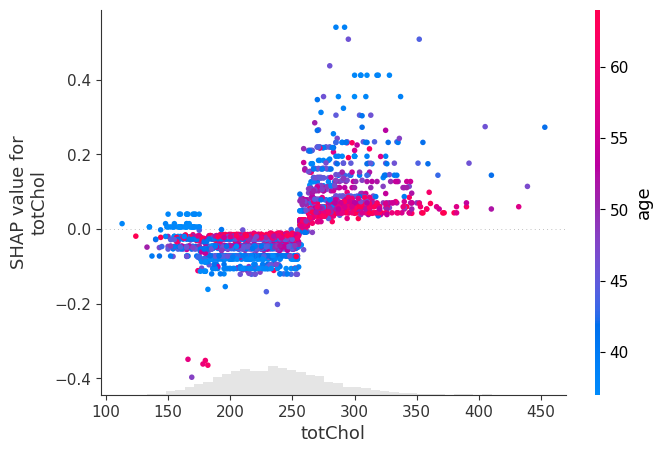

In [51]:
## visualize some of the interaction between feature by coloring according to another variable 
shap.plots.scatter( shap_values[:,'totChol'] , color=shap_values[:,'age'] )

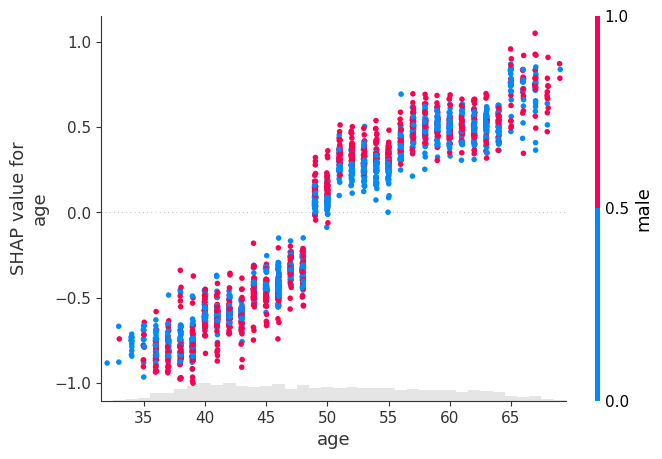

In [52]:
## If you give all shap_values, the library searched for the one which may interact the most
shap.plots.scatter( shap_values[:,'age'] , color=shap_values )

## SHAP interaction values

In [53]:
%%time
shap_interaction_values = explainer.shap_interaction_values(X_train)

CPU times: user 1.11 s, sys: 12 ms, total: 1.12 s
Wall time: 162 ms


<Axes: >

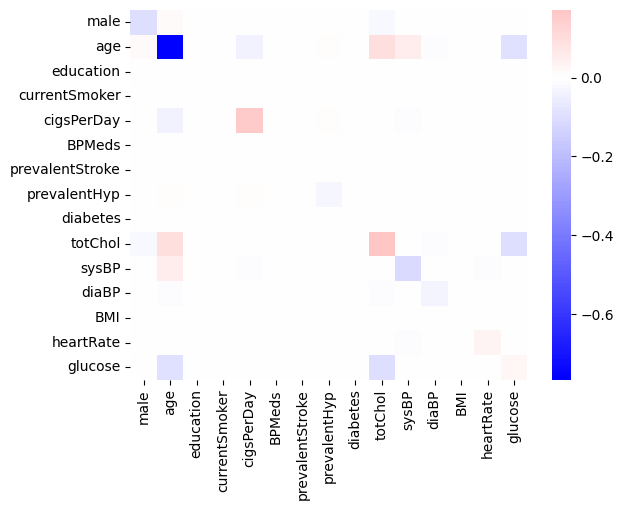

In [54]:
import seaborn as sns
sns.heatmap( shap_interaction_values[1], 
            xticklabels = X_train.columns,
            yticklabels = X_train.columns,
           center = 0, cmap = 'bwr')

In [55]:
shap_values[1].values

array([-0.10993919, -0.75558966, -0.00208886,  0.        ,  0.10945176,
        0.        ,  0.        , -0.01126399,  0.        ,  0.13790041,
       -0.08331777, -0.06182055, -0.00258954,  0.0178487 , -0.17080778],
      dtype=float32)

In [56]:
shap_interaction_values[1].sum(axis = 1)

array([-0.10993919, -0.75558966, -0.00208886,  0.        ,  0.10945176,
        0.        ,  0.        , -0.01126399,  0.        ,  0.13790043,
       -0.08331776, -0.06182055, -0.00258954,  0.0178487 , -0.17080778],
      dtype=float32)

/home/wandrille/Installed_software/anaconda3/envs/intermediateML_2024_2/lib/python3.11/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 3 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")


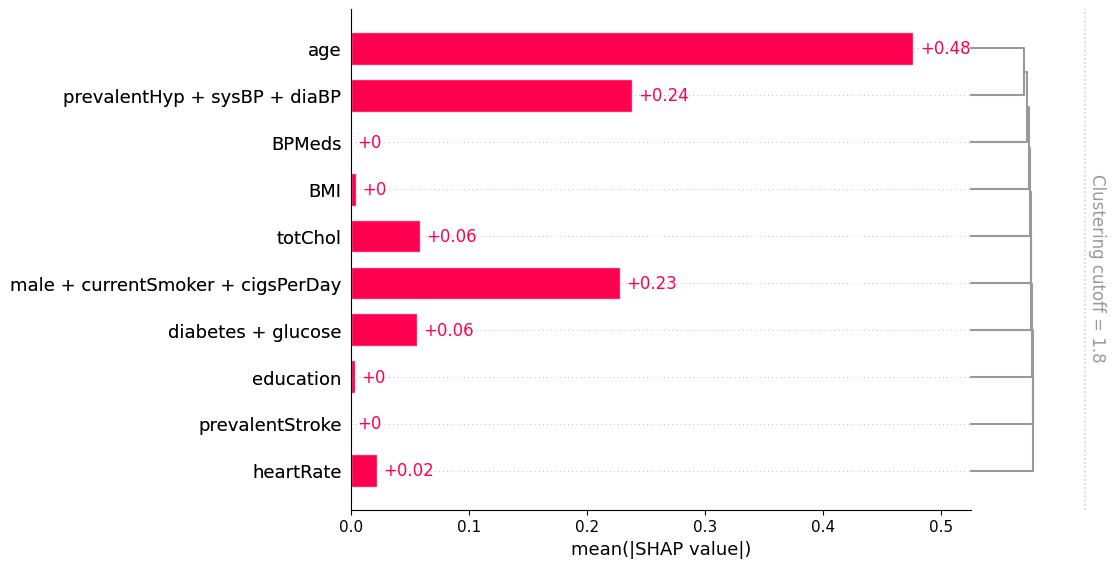

In [57]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(shap_values, clustering=clustering,clustering_cutoff=1.8)

## exercise

We train a similar model, but with max_depth fixed to 1 and then look at their SHAP values ?


In [58]:
model_xgb2 = xgboost.XGBClassifier(n_estimators=100, 
                                  max_depth=1,
                                  early_stopping_rounds=10 ,
                                  eval_metric= 'auc')
model_xgb2.fit(X_train, y_train, 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=True)


[0]	validation_0-auc:0.64708	validation_1-auc:0.63280
[1]	validation_0-auc:0.68292	validation_1-auc:0.66947
[2]	validation_0-auc:0.69205	validation_1-auc:0.67592
[3]	validation_0-auc:0.70374	validation_1-auc:0.67600
[4]	validation_0-auc:0.70666	validation_1-auc:0.68561
[5]	validation_0-auc:0.71037	validation_1-auc:0.68776
[6]	validation_0-auc:0.72102	validation_1-auc:0.70329
[7]	validation_0-auc:0.72469	validation_1-auc:0.70924
[8]	validation_0-auc:0.72795	validation_1-auc:0.71209
[9]	validation_0-auc:0.73393	validation_1-auc:0.71804
[10]	validation_0-auc:0.73430	validation_1-auc:0.71570
[11]	validation_0-auc:0.73504	validation_1-auc:0.71590
[12]	validation_0-auc:0.73815	validation_1-auc:0.71936
[13]	validation_0-auc:0.73701	validation_1-auc:0.71844
[14]	validation_0-auc:0.73854	validation_1-auc:0.71697
[15]	validation_0-auc:0.74024	validation_1-auc:0.71864
[16]	validation_0-auc:0.74071	validation_1-auc:0.72047
[17]	validation_0-auc:0.74189	validation_1-auc:0.72318
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [59]:
explainer2 = shap.Explainer( model_xgb2 ) ## creates an explainer from our model
shap_values2 = explainer2(X_train) ## compute shap values for the prediction of the models on some data

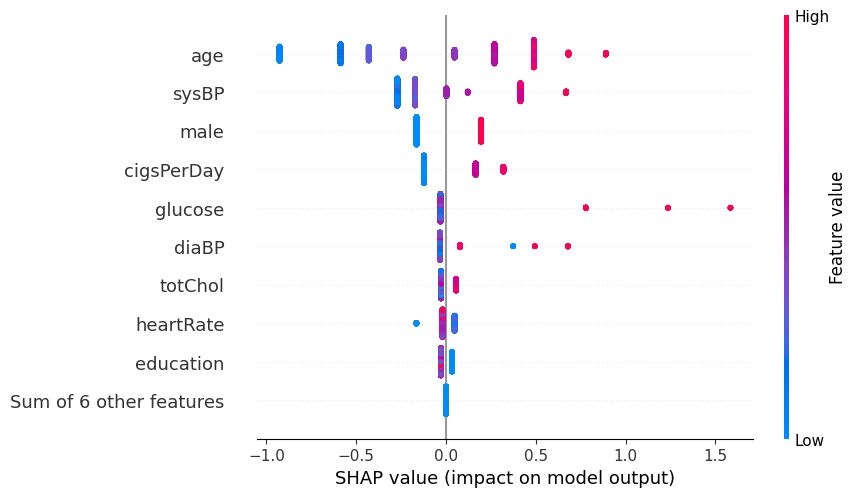

In [60]:
shap.plots.beeswarm(shap_values2)

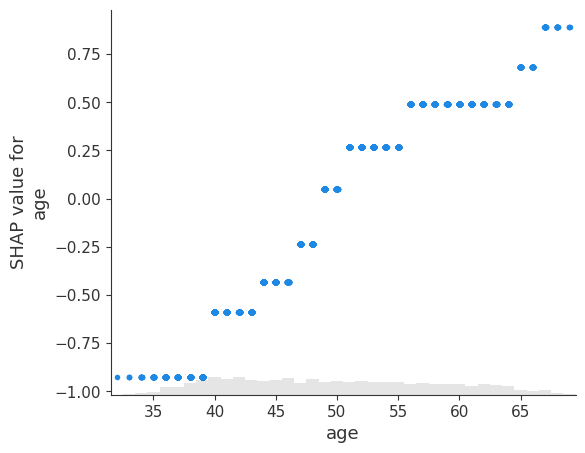

In [61]:
shap.plots.scatter( shap_values2[:,'age'] )

The relative importance of variables broadly stays the same, but the pattern of SHAP values is definitely different.

Why do you think that is?

## different explainer types

In [62]:
%%time
explainer = shap.Explainer( model_xgb2 ) ## defaults to TreeExplainer
# TreeExplainer: 
#  * explores the tree ensemble to compute the SHAP values efficiently
#  * somewhat built-in the trees libraries nowadays -> extra fast computation
shap_values = explainer(X_train) 


CPU times: user 302 ms, sys: 0 ns, total: 302 ms
Wall time: 48.8 ms


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


Xt_scaled = StandardScaler().fit_transform(X_train)

LR = LogisticRegression()
LR.fit(Xt_scaled, y_train)


LogisticRegression()

In [64]:
%%time

explainer = shap.Explainer( LR ) 
shap_values = explainer(Xt_scaled) 

explainer

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression()

In [65]:
%%time
explainer = shap.Explainer( LR.predict_proba , Xt_scaled[:100,:] ) 
shap_values = explainer(Xt_scaled[:100,:]) 

explainer

CPU times: user 675 ms, sys: 0 ns, total: 675 ms
Wall time: 673 ms


[permutation explainer](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Permutation.html)
 * uses smart permutation scheme to estimate SHAP values
 * needs a "background" sample which is used to "simulate" values for the masked features

An alternative is to explicitely say that it is a Linear model:

In [66]:
%%time
# explain the model's predictions using SHAP
explainer = shap.explainers.Linear(LR, Xt_scaled[:100,:])
shap_values = explainer(Xt_scaled[:100,:])

CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 14.5 ms


In [67]:
explainer

But in some case you won't have a choice and you need to go for a "generic" explainer such as PermutationExplainer

For example, for a KNN:

In [68]:
%%time 
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(Xt_scaled, y_train)


explainer = shap.Explainer( KNN.predict_proba , Xt_scaled[:100,:]) 
shap_values = explainer(Xt_scaled[:100,:]) 

PermutationExplainer explainer: 101it [03:28,  2.19s/it]                                                                                                                                                                                                                          

CPU times: user 3min 28s, sys: 32.2 ms, total: 3min 28s
Wall time: 3min 28s


See the API documentation for [other "explainers"](https://shap.readthedocs.io/en/latest/api.html#explainers), either generic or adapted to specific kind of models.


## causation, correlation, and interpretation of predictive models

We are sure you have heard it a large number of time, but this message really is really worth repeating.

The SHAP documentation actually proposes an [insightful article](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.html) on the topic of misleading interpretation.

Our advise is to read it attentively, meditate on the subject, and then read it again.

